# Analysing WaPOR data

This notebook contains code example to analyse WaPOR data, including:
- [1. Calculate the average value of ROI](#1.-Calculate-the-average-value-of-ROI)
- [2. Working with timeseries (pandas library)](#2.-Working-with-timeseries-(pandas-library))
- [3. Raster calculation](#3.-Raster-calculation)
- [4. Land-use analysis](#4.-Land-use-analysis)

After the examples, there will be some coding exercises for you to practice.

### Import libraries and functions
For this exercise, we can make use of the user-defined functions we made in the previous exercise to read can write raster data. 

*First, run the code cell below to import all of them.*

In [2]:
import numpy as np
import gdal
import osr
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ogr
import datetime

def GetGeoInfo(fh, subdataset = 0):
    """
    Substract metadata from a geotiff, HDF4 or netCDF file.
    
    Parameters
    ----------
    fh : str
        Filehandle to file to be scrutinized.
    subdataset : int, optional
        Layer to be used in case of HDF4 or netCDF format, default is 0.
        
    Returns
    -------
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.
    """
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    """
    Open a map as an numpy array. 
    
    Parameters
    ----------
    fh: str
        Filehandle to map to open.
    bandnumber : int, optional 
        Band or layer to open as array, default is 1.
    dtype : str, optional
        Datatype of output array, default is 'float32'.
    nan_values : boolean, optional
        Convert he no-data-values into np.nan values, note that dtype needs to
        be a float if True. Default is False.
        
    Returns
    -------
    Array : ndarray
        Array with the pixel values.
    """
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16,
                 "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
                 "int32": np.int32, "float32": np.float32, "float64": np.float64, 
                 "complex64": np.complex64, "complex128": np.complex128,
                "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, 
                 "Complex64": np.complex64, "Complex128": np.complex128,}
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, Projection, explicit = True, compress = None):
    """
    Creates a geotiff from a numpy array.
    
    Parameters
    ----------
    fh : str
        Filehandle for output.
    Array: ndarray
        Array to convert to geotiff.
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.    
    """
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan


def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Matches the projection, resolution and no-data-value of a list of target-files
    with a source-file and saves the new maps in output_dir.
    
    Parameters
    ----------
    source_file : str
        The file to match the projection, resolution and ndv with.
    target_fhs : list
        The files to be reprojected.
    output_dir : str
        Folder to store the output.
    resample : str, optional
        Resampling method to use, default is 'near' (nearest neighbour).
    dtype : str, optional
        Datatype of output, default is 'float32'.
    scale : int, optional
        Multiple all maps with this value, default is None.
    
    Returns
    -------
    output_files : ndarray 
        Filehandles of the created files.
    """
    dst_info=gdal.Info(gdal.Open(source_file),format='json')
    output_files = np.array([])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for target_file in target_fhs:
        folder, fn = os.path.split(target_file)
        src_info=gdal.Info(gdal.Open(target_file),format='json')
        output_file = os.path.join(output_dir, fn)
        gdal.Warp(output_file,target_file,format='GTiff',
                      srcSRS=src_info['coordinateSystem']['wkt'],
                      dstSRS=dst_info['coordinateSystem']['wkt'],
                      srcNodata=src_info['bands'][0]['noDataValue'],
                      dstNodata=dst_info['bands'][0]['noDataValue'],
                      width=dst_info['size'][0],
                      height=dst_info['size'][1],
                      outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                    dst_info['cornerCoordinates']['lowerLeft'][1],
                                    dst_info['cornerCoordinates']['upperRight'][0],
                                    dst_info['cornerCoordinates']['upperRight'][1]),
                      outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                      resampleAlg=resample)
        output_files = np.append(output_files, output_file)
        if not np.any([scale == 1.0, scale == None, scale == 1]):
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = True) * scale
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
        if ndv_to_zero:
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = False)
            DATA[DATA == NDV] = 0.0
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_files

def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    Clip raster to boundary line of a shapefile
    
    Parameters
    ----------
    input_fhs : list
        The list of input raster files
    output_folder : str
        The path to folder where to save output rasters
    shp_fh : str
        Folder to store the output.
    NDV : float or int, optional
        No Data Value of output raster
        
    Returns
    -------
    output_fhs : list 
        Filehandles of the created files.
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )
    output_fhs=[]
    for input_fh in input_fhs:
        output_fh=os.path.join(output_folder,os.path.basename(input_fh))
        sourceds = gdal.Warp(output_fh, input_fh, options = options)
        output_fhs.append(output_fh)
    return output_fhs

## 1. Calculate the average value of ROI
### Example
In order to calculate average precipitation in a Region of Interest (ROI) from a raster map (mm/month), we need to clip the raster map to cutline of the ROI shapefile. By doing this, we exclude all the pixels outside of the ROI. In this example, we will use the resulted rasters in exercise 3 of the previous [notebook](2_Preprocess_WaPOR_data.ipynb), which are precipitation maps clipped with Awash River Basin shapefile, which is our ROI.

First, we will get the list of clipped precipitation raster files

In [3]:
P_folder=r".\data\L1_PCP_M_clipped" #input folder
# Get list of files in folder:
P_fhs=sorted(glob.glob(os.path.join(P_folder,'*.tif')))
P_fhs

['.\\data\\L1_PCP_M_clipped\\L1_PCP_0901M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0902M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0903M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0904M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0905M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0906M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0907M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0908M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0909M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0910M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0911M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_0912M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1001M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1002M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1003M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1004M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1005M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1006M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1007M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1008M.tif',
 '.\\data\\L1_PCP_M_clipped\\L1_PCP_1009

Now, we will first calculate the average precipitation in Awash River Basin of the first raster file in the list as an example. We can get the average Precipitation of the whole area by *numpy.nanmean* which means calculate the average excluding pixels with nan values.

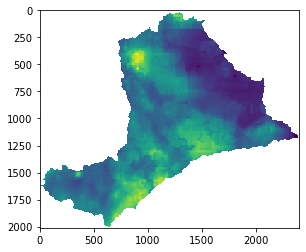

Average Precipitation (mm/month): 25.643678665161133


In [4]:
in_fh=P_fhs[0] #get the first raster file in the list
P=OpenAsArray(in_fh,nan_values=True) #open the raster as array
plt.imshow(P)
plt.show()
Average_P=np.nanmean(P) #get the mean values
print('Average Precipitation (mm/month): {0}'.format(Average_P))

To get values of all monthly Precipitation (P) maps and save the value in a Python *list* and plot average precipitation against time, we will loop over all the monthly P rasters and calculate average P and the date.

We can make use of the file name to get *datetime* index. Look at example below.

In [5]:
dates=[] 
months=[]
years=[]
P_values=[]
for P_fh in P_fhs:
    filename=os.path.basename(P_fh) # get file name from filehandler string
    datestr=filename.split('.')[0].split('_')[-1] #get date string from file name
    dyear=int('20'+datestr[0:2]) #get year number from date string
    dmonth=int(datestr[2:4]) #get month number from date string
    dates.append(datetime.date(dyear,dmonth,1)) # create datetime object from year and month number
    months.append(dmonth) #append to months list
    years.append(dyear) # append to years list
    #Calculate value
    P=OpenAsArray(P_fh,nan_values=True) #open raster as numpy array    
    Average_P=np.nanmean(P) # calculate average P
    P_values.append(Average_P)    #append to P_values list

After extract monthly average value of the rasters, we can plot the **P_values** to see the results

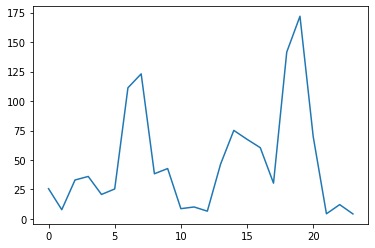

In [6]:
plt.plot(P_values)
plt.show()

We can decorate our graph with some extra code. For example, run the code below and see the output graph. You can try to customize the graph.

C:\Users\ntr002\Anaconda3\envs\waporocw\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


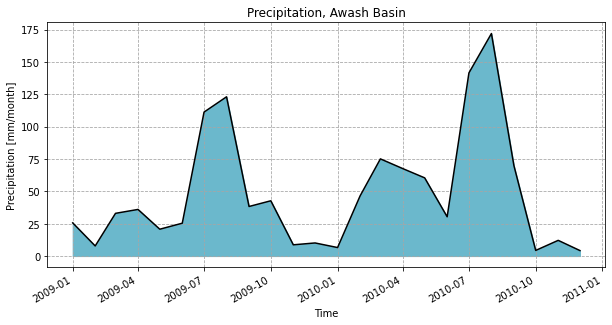

In [7]:
output_dir=r'.\data'
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) # Add Grid line
ax = plt.subplot(111)
ax.plot(dates, P_values, '-k') #Plot data as black line
ax.fill_between(dates, P_values, color = '#6bb8cc') #Fill line area with blue color
ax.set_xlabel('Time') #Add X axis title
ax.set_ylabel('Precipitation [mm/month]') #Add Y axis title
ax.set_title('Precipitation, Awash Basin') #Add Figure title
fig.autofmt_xdate() #auto-format dates axis
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_ts.png')) #save figure to output
plt.show()

## 2. Working with timeseries (pandas library)
### Example
The lists created (*dates*, *months*, *years*, *P_values*) can be combined in a DataFrame object using *pandas.DataFrame*. This structure makes cleaning, transforming, manipulating and analyzing data easier. For example, the code below create a DataFrame from the list of dates and average Precipitation values.

In [8]:
P_df=pd.DataFrame({'date':dates,'month':months,'year':years,'value': P_values})
P_df

,date,month,year,value
0,2009-01-01,1,2009,25.643679
1,2009-02-01,2,2009,7.820275
2,2009-03-01,3,2009,33.018497
3,2009-04-01,4,2009,36.029739
4,2009-05-01,5,2009,20.754398
5,2009-06-01,6,2009,25.401539
6,2009-07-01,7,2009,111.232544
7,2009-08-01,8,2009,123.038208
8,2009-09-01,9,2009,38.304550
9,2009-10-01,10,2009,42.717953


For example, we can easily sum up precipitation of the monthly values into the yearly total precipitation using *groupby* of column *year* with method *sum*.

In [9]:
Year_total=P_df.groupby(['year']).sum()
Year_total['value']

year
2009    482.798503
2010    690.440463
Name: value, dtype: float64

DataFrame columns can be converted to array and plotted easily. Below is the code to plot the total yearly precipitation. 

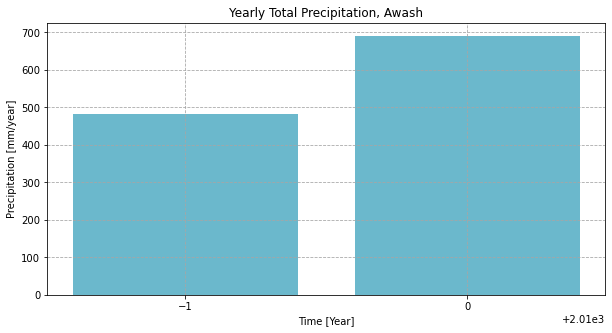

In [10]:
fig = plt.figure(figsize = (10,5))
ax2 = plt.subplot(111)
ax2.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax2.bar(Year_total.index, Year_total['value'].values, 0.8, color = '#6bb8cc')
ax2.set_xlabel('Time [Year]')
ax2.set_xticks(Year_total.index)
ax2.set_ylabel('Precipitation [mm/year]')
ax2.set_title('Yearly Total Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_year.png'))
plt.show()
plt.close(fig)

To calculate and plot the mean Precipitation of the calendar months, we can *groupby* method, and use *mean* instead of *sum*: **P_df.groupby(['month']).mean()**

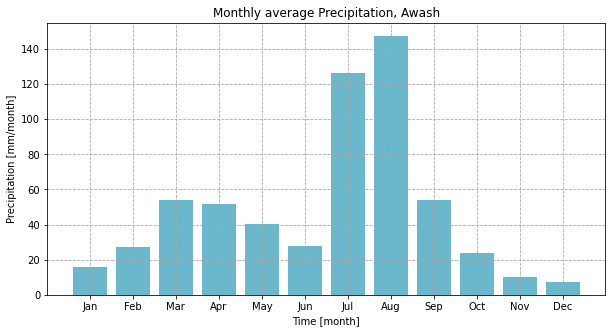

In [11]:
Month_avg=P_df.groupby(['month']).mean()
Month_avg['value']
fig = plt.figure(figsize = (10,5))
#subplot 1
ax1 = plt.subplot(111)
ax1.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax1.bar(Month_avg.index, Month_avg['value'].values, 0.8, color = '#6bb8cc')
ax1.set_xlabel('Time [month]')
monthname={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthslabel=monthname.values()
ax1.set_xticks(Month_avg.index)
ax1.set_xticklabels(monthslabel)
ax1.set_ylabel('Precipitation [mm/month]')
ax1.set_title('Monthly average Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_month.png'))
plt.show()
plt.close(fig)

We can also save our dataframe as csv file using pandas.DataFrame method *to_csv* for later use in other analysis. 

In [12]:
Month_max=P_df.groupby(['month']).max()
Month_min=P_df.groupby(['month']).min()
Month_med=P_df.groupby(['month']).median()
Month_std=P_df.groupby(['month']).std()

Month_stat=pd.DataFrame({'month': Month_avg.index,'Mean':Month_avg['value'].values,
                        'Max':Month_max['value'].values, 'Min':Month_min['value'].values,
                        'Median':Month_med['value'].values,'Std':Month_std['value'].values})
print(Month_stat)
Month_stat.to_csv(r'.\data\P_month_stats.csv',sep=';')

    month        Mean         Max         Min      Median        Std
0       1   16.115124   25.643679    6.586569   16.115124  13.475411
1       2   27.138358   46.456440    7.820275   27.138358  27.319894
2       3   54.050253   75.082008   33.018497   54.050253  29.743394
3       4   51.782978   67.536217   36.029739   51.782978  22.278444
4       5   40.590412   60.426426   20.754398   40.590412  28.052360
5       6   27.875678   30.349817   25.401539   27.875678   3.498961
6       7  126.365967  141.499390  111.232544  126.365967  21.401892
7       8  147.474548  171.910889  123.038208  147.474548  34.558204
8       9   54.071995   69.839439   38.304550   54.071995  22.298534
9      10   23.540389   42.717953    4.362825   23.540389  27.121171
10     11   10.420251   12.142183    8.698319   10.420251   2.435179
11     12    7.193530   10.138801    4.248259    7.193530   4.165242


## 3. Raster calculation
### Example: P - ET
First, we need to get the file handler of the P and ET rasters of the same date that have been matched projection, size and resolution. We can make use of the time format in file name as below.

In [13]:
start_date='2009-01-01'
end_date='2010-12-31'
dates=pd.date_range(start_date,end_date,freq='M') #create a date range from start_date and end_date

P_path=r'.\data\L1_PCP_M_clipped\L1_PCP_{:2}{:02d}M.tif' #template string to format
ET_path=r'.\data\L1_AETI_M_clipped\L1_AETI_{:2}{:02d}M.tif' #template string to format

date=dates[0] #get the first date in the date range
print(date)
P_fh=P_path.format(str(date.year)[2:],date.month) #format filename using the selected date
ET_fh=ET_path.format(str(date.year)[2:],date.month) #format filename using the selected date
print(P_fh)
print(ET_fh)

2009-01-31 00:00:00
.\data\L1_PCP_M_clipped\L1_PCP_0901M.tif
.\data\L1_AETI_M_clipped\L1_AETI_0901M.tif


The difference between Precipitation and Total EvapoTranspiration (P-ET) of the pixel can indicate whether the pixel is sink or source of water. When P-ET>0, water is generated in the pixel area. When P-ET< 0, water is more depleted in the pixel area. For example, below is how we can calculate P-ET for one month (January 2009). Notice where P-ET is negative and positive.

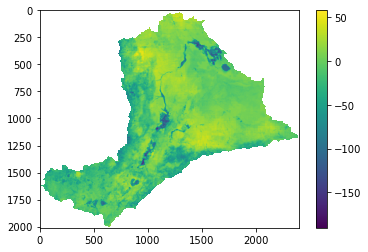

In [14]:
P=OpenAsArray(P_fh,nan_values=True)
ET=OpenAsArray(ET_fh,nan_values=True)
P_ET=P-ET
plt.imshow(P_ET)
plt.colorbar()
plt.show()

We can use a for-loop to calculate P-ET maps for the month in 2009. The output files will be save in the folder [P-ET_M](data/P-ET_M)

In [15]:
output_folder=r'.\data\P-ET_M'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for date in dates:
    print(date)
    P_fh=P_path.format(str(date.year)[2:],date.month) #format filename using the selected date
    ET_fh=ET_path.format(str(date.year)[2:],date.month) #format filename using the selected date 
    driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(P_fh)
    P=OpenAsArray(P_fh,nan_values=True)
    ET=OpenAsArray(ET_fh,nan_values=True)
    P_ET=P-ET
    filename='P-ET_{:2}{:02d}M.tif'.format(str(date.year)[2:],date.month)
    output_fh=os.path.join(output_folder,filename)
    print(output_fh)
    CreateGeoTiff(output_fh, P_ET, driver, NDV, xsize, ysize, GeoT, Projection)

2009-01-31 00:00:00
.\data\P-ET_M\P-ET_0901M.tif
2009-02-28 00:00:00
.\data\P-ET_M\P-ET_0902M.tif
2009-03-31 00:00:00
.\data\P-ET_M\P-ET_0903M.tif
2009-04-30 00:00:00
.\data\P-ET_M\P-ET_0904M.tif
2009-05-31 00:00:00
.\data\P-ET_M\P-ET_0905M.tif
2009-06-30 00:00:00
.\data\P-ET_M\P-ET_0906M.tif
2009-07-31 00:00:00
.\data\P-ET_M\P-ET_0907M.tif
2009-08-31 00:00:00
.\data\P-ET_M\P-ET_0908M.tif
2009-09-30 00:00:00
.\data\P-ET_M\P-ET_0909M.tif
2009-10-31 00:00:00
.\data\P-ET_M\P-ET_0910M.tif
2009-11-30 00:00:00
.\data\P-ET_M\P-ET_0911M.tif
2009-12-31 00:00:00
.\data\P-ET_M\P-ET_0912M.tif
2010-01-31 00:00:00
.\data\P-ET_M\P-ET_1001M.tif
2010-02-28 00:00:00
.\data\P-ET_M\P-ET_1002M.tif
2010-03-31 00:00:00
.\data\P-ET_M\P-ET_1003M.tif
2010-04-30 00:00:00
.\data\P-ET_M\P-ET_1004M.tif
2010-05-31 00:00:00
.\data\P-ET_M\P-ET_1005M.tif
2010-06-30 00:00:00
.\data\P-ET_M\P-ET_1006M.tif
2010-07-31 00:00:00
.\data\P-ET_M\P-ET_1007M.tif
2010-08-31 00:00:00
.\data\P-ET_M\P-ET_1008M.tif
2010-09-30 00:00:00


## Exercise 1
Follow the example of how monthly average Precipitation was calculated in the examples, calculate and plot monthly P - ET of the year 2009 and 2010 in Awash Basin. 

In [ ]:
'''Write your code here'''

## 4. Land-use analysis
### Example:
We will first clip the WaPOR LCC rasters downloaded from [3 Bulk download WaPOR data](3_Bulk_download_WaPOR_data.ipynb) then get the list of unique Land Cover classes from WaPOR Land Cover Classification rasters.

In [16]:
shp_fh=r".\data\Awash_shapefile.shp"
LCC_folder=r'.\data\WAPOR.v2_yearly_L1_LCC_A'
LCC_fhs=sorted(glob.glob(os.path.join(LCC_folder,'*.tif'))) #get list of LCC rasters
output_folder=r'.\data\WAPOR.v2_yearly_L1_LCC_A_clipped' # New LCC folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder) #create new P folder
LCC_fhs=CliptoShp(LCC_fhs,output_folder,shp_fh) #clip all LCC rasters to shapefile

We will open 1 LCC map as numpy array to get the unique values in map. These are the Land Cover Classification codes. For the description of these LCC codes, see the Land Cover Classification metadata on WaPOR catalog https://wapor.apps.fao.org/catalog/WAPOR_2/1/L1_LCC_A

| code        | Name          | 
| :---------: |:-------------:| 
| 20 | Shrubland      | 
| 30      |  Grassland      | 
| 41      | Cropland, rainfed      | 
| 42      | Cropland, irrigated or under water management  |
| 43      | Cropland, fallow |   
| 50 | Built-up      |  
| 60 | Bare / sparse vegetation       | 
| 80 | Water bodies       | 
| 112 | Tree cover: closed, evergreen broadleaved      | 
| 114 |  Tree cover: closed, deciduous broadleaved | 
| 116 | Tree cover: closed, unknown type | 
| 124 | Tree cover: open, deciduous broadleaved | 
| 126 |  Tree cover: open, unknown type  | 

In [17]:
LCC_fh=r".\data\WAPOR.v2_yearly_L1_LCC_A_clipped\L1_LCC_09.tif"
LCC=OpenAsArray(LCC_fh,nan_values=True)
LCC_values=np.unique(LCC[~np.isnan(LCC)])
LCC_codes=list(LCC_values)
print(LCC_codes)

[20.0, 30.0, 41.0, 42.0, 43.0, 50.0, 60.0, 80.0, 90.0, 112.0, 114.0, 116.0, 124.0, 126.0]


To calculate average ET of each land cover, we can mask the ET map where the LCC map values equal to each LCC code, then calculate **np.nanmean** of the masked array.
For example, to get ET value of water bodies (the LCC code is 80), we can use the steps below

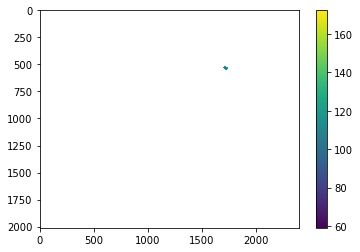

In [19]:
code=80 #Water bodies

mask=np.where(LCC==code,0,1)
in_fh=r".\data\L1_AETI_M_clipped\L1_AETI_0901M.tif"
var=OpenAsArray(in_fh,nan_values=True)

import numpy.ma as ma #import mask array module
masked_map=ma.masked_array(var,mask)
plt.imshow(masked_map)
plt.colorbar()
plt.show()

After that, we can calculate average ET of a the water bodies land-use class using the masked array

In [20]:
average=np.nanmean(masked_map)
print('Landuse class {0} Average: {1}'.format(code,average))

Landuse class 80 Average: 104.69696044921875


Now, we can use a for-loop over the unique LCC codes to calculate average ET value of each LCC code.

In [21]:
averages=[]
for code in LCC_codes:
    mask=np.where(LCC==code,0,1)
    masked_map=ma.masked_array(var,mask)
    averages.append(np.nanmean(masked_map))
LCC_avg=pd.DataFrame({'LCC code':LCC_codes,'Average Value': averages})
LCC_avg

,LCC code,Average Value
0,20.0,37.537735
1,30.0,17.037479
2,41.0,47.709606
3,42.0,78.880722
4,43.0,6.646875
5,50.0,25.989452
6,60.0,8.477416
7,80.0,104.696960
8,90.0,100.415855
9,112.0,118.877800


## Exercise 2:

Calculate a table of average annual P-ET in Awash basin of all land-use class for the year 2009. 

**Hint**: The first step is to sum all the monthly P-ET rasters in the year 2009.

2009-01-31 00:00:00
2009-02-28 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-05-31 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-10-31 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00


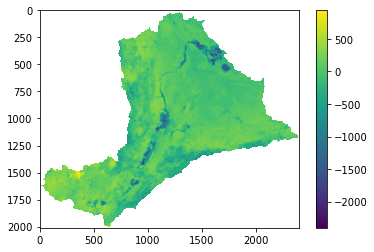

In [22]:
start_date='2009-01-01'
end_date='2009-12-31'
dates=pd.date_range(start_date,end_date,freq='M') #create a date range from start_date and end_date
PmET_path=r'.\data\P-ET_M\P-ET_{:2}{:02d}M.tif'
sameple_file=PmET_path.format(str(dates[0].year)[2:],dates[0].month)
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(sameple_file)

SumArray=np.zeros((ysize,xsize)) #creates an array of zeros
for date in dates:
    print(date)
    PmET_fh=PmET_path.format(str(date.year)[2:],date.month) #format filename using the selected date
    SumArray+=OpenAsArray(PmET_fh,nan_values=True) #cumulatively saves each array of monthly averages to the array of zeros

output_fh=os.path.join('.\data\P-ET_2009.tif') #name of the output file
CreateGeoTiff(output_fh, SumArray, driver, NDV, x size, ysize, GeoT, Projection) #creates a geotiff from SumArray
plt.imshow(SumArray)
plt.colorbar()
plt.show()

**Hint**: Then, using the similar steps that were used to calculate average ET of each land cover class, calculate average P -ET per land cover class.

Compare Evaporation in the main classes: Forest, Shrubland, Grassland, Water bodies, Bare land, Rainfed crops, Irrigated crops.

In [ ]:
'''Write your code here'''